# Lib

In [6]:
import os 
import re 
import requests 
from bs4 import BeautifulSoup  
import pandas as pd 
from pathlib import Path
import nltk 
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from IPython.display import Image, display, Markdown

# 0: Before we start
* Jupyter notebook
* Libraries
* Some tricks

In [11]:
DOCUMENTS_PATH = "C:\SP\Teaching\DSCamp\gifs"

# A. Programming Review

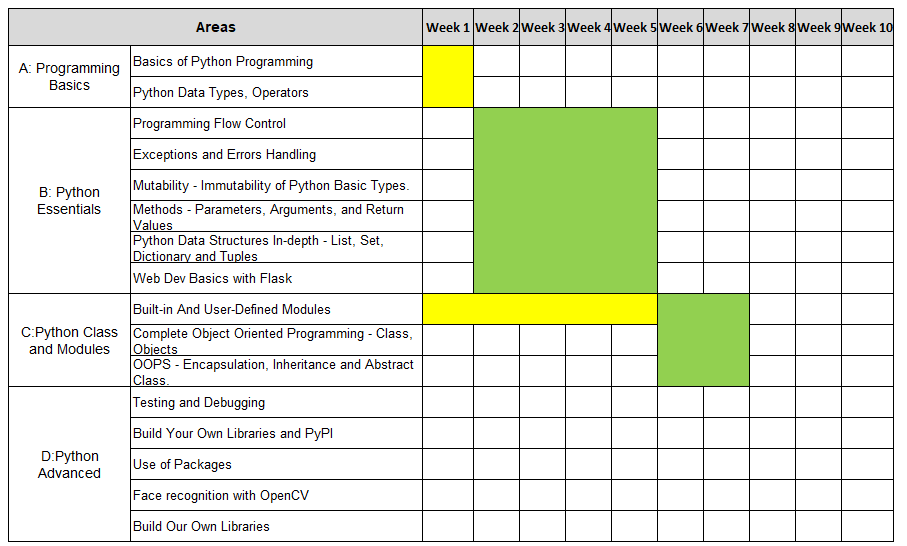

In [15]:
Image(f"{DOCUMENTS_PATH}\session02_01.png")

### For those who would like to review the fundamentals:

#### Five  

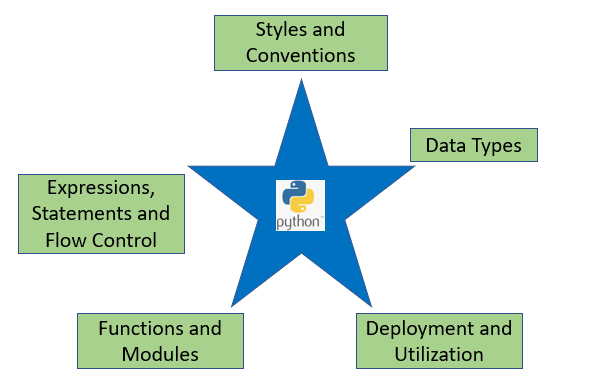

In [18]:
Image(f"{DOCUMENTS_PATH}\session02_02.png")

#### Stypes
* readability and consistence
* PEP 8 
* most important:
<br> &nbsp;&nbsp;&nbsp;&nbsp;indentation
<br> &nbsp;&nbsp;&nbsp;&nbsp;function naming, variable naming convention
<br> &nbsp;&nbsp;&nbsp;&nbsp; surround a whitespace around operators 
* more at <a href = "https://peps.python.org/pep-0008/"> PEP 8 </a>

#### Datatypes:
* Text Type:	str
* Numeric Types:	int, float, complex
* Sequence Types:	list, tuple, range
* Mapping Type:	dict
* Set Types:	set, frozenset
* Boolean Type:	bool
* Binary Types:	bytes, bytearray, memoryview
* None Type:	NoneType

<font size = 4 color = red> discussion: </font>
* what if I ask you to use data type variables to hold the subject you are learning. 
* what about for scores of these subjects?

#### Expressions, Statement and flow control
* there is not a clean line between expr and statement (especially when it comes list data). In general:
* Expr is something, and statement is do something
* and flow is logical sequence of doing something

<font size = 4 color = red> discussion: </font>
* from last section, Data Types, write few lines that only print out subjects you got between 85 and 95 (if in number scale)

#### functions and modules
* why do we need a function?
* on a high level, there are two types of functions. built-in and udf
* since function is meant to be reusable, the Parameters matters.  . we will cover more later

<font size = 4 color = red> discussion: </font>
* what if we want to let every one use the some code above?

#### Modules and deployment 
* cover later

# B Our First Accessory: word list 
* Objectives: 
<ol>
    <li> copy and paste: scraping basics</li>
    <li> python in action </li>
    <li> build our own sat word flash card </li>
</ol>


In [20]:
url = "https://satvocabulary.us/INDEX.ASP?CATEGORY=6000LIST"
response = requests.get(url) 
soup = BeautifulSoup(response.content, "html.parser") ## response.content is in binary. response.text is in unicode 
tables = soup.find_all("table") 
for table in soup.find_all('table'): 
    print(table.get('class'))
    # Ctrl + U to exame the page. or go to menus 

None
['WORDLIST']


### method one:

In [21]:
table = soup.find('table', class_='WORDLIST') 

# Defining of the dataframe 
list_of_words = []
# Collecting Ddata
for row in table.find_all('tr'):  
    # some table has tbody
    # Find all data for each column
    columns = row.find_all("td")
 
    if(columns != []):
        Seq = columns[0].text.strip()
       
        WORD = columns[1].text.strip()
     
        DEFINITION = columns[2].text.strip() 
        GROUPING = columns[3].text.strip()
        
        list_of_words.append([Seq, WORD, DEFINITION, GROUPING]) 
df = pd.DataFrame(data = list_of_words[1:],  columns=['Seq', 'WORD', 'DEFINITION', 'GROUPING' ])

### method two

In [ ]:
table = soup.find('table', class_='WORDLIST')  
# Defining of the dataframe
df = pd.DataFrame(columns=['Seq', 'WORD', 'DEFINITION', 'GROUPING' ])

# Collecting Ddata
for row in table.find_all('tr'):  
    # some table has tbody
    # Find all data for each column
    columns = row.find_all("td")
 
    if(columns != []):
        Seq = columns[0].text.strip()
       
        WORD = columns[1].text.strip()
     
        DEFINITION = columns[2].text.strip() 
        GROUPING = columns[3].text.strip()

        df = df.append({'Seq': Seq,  'WORD': WORD, 'DEFINITION': DEFINITION, 'GROUPING': GROUPING}, ignore_index=True) 

df = df[df["Seq"] != ""]

### save to a csv file

In [24]:
file_name = "Session_01_SAT_Vocab.csv"  
output_file_foler = os.getcwd() 
output_file = Path(output_file_foler, file_name)
df_words = df.to_csv(output_file, index = False) 
 

### wrap it to a function 

### dissecting part B.

### <font color = red > homeword and further study: </font>
* homework: try to scrape one other page, e.g.: "https://www.topuniversities.com/sites/default/files/qs-rankings-data/en/3740566_indicators.txt?1637817445?v=1637823042256" 
* https://realpython.com/beautiful-soup-web-scraper-python/

# C. enrich our vocab: next week 

In [24]:
def get_wn_tag(tag):
    """
        input: tag is the Grouping in the sat word list
        output: the tagging that required by NLTK 
    """  
    if tag in ['adjective', 'adj']:
        return wn.ADJ
    elif tag in ['adverb', "adv"]:
        return wn.ADV
    #elif tag in ['noun']:
    #    return wn.NOUN
    elif tag in ['verb']:
        return wn.VERB 
    else:
        return wn.NOUN

In [25]:
def synonym_antonyms_parser(token = "notebook",  tag = "noun", *args, **kwargs  ):  
    """
        input: token，one of the word in SAT 6000
        output: synonym, antonym and sample sentences, if with_example_sentence set to True 
        *args, **kwargs: more to elaborate
    """
    # get the the tag used in nltk
    wn_tag = get_wn_tag(tag) 
    
    # result list. in format of [token, seq, definition, sample sentences, synonyms, antonyms]
    result = []
    
    synsets = wn.synsets(token,wn_tag)
    
    if not synsets: 
        return [[token, 1, "", "", "", ""]] # just return the token. other fields to be blank
    
    for i, synset in enumerate(synsets): 
        
        one_row = [token, i + 1] 
        
        one_row.append(synset.definition()) 
        
        #sentences. make first Character in capital
        examples = synset.examples()
        examples = [example[0].upper()+example[1:] for example in examples] 
        one_row.append('. '.join(examples))
         
        # handle synonyms and antonyms
        synonyms_words, antonyms_words = [], []
        
        lemmas = synset.lemmas() 
        for word in lemmas: 
            synonyms_words.append(word.name()) 
            
            antonyms = word.antonyms() 
           
            for antonym in antonyms: 
                antonyms_words.append(antonym.name())
                
        one_row.append('. '.join(synonyms_words))
        one_row.append('. '.join(antonyms_words))
       
        result.append(one_row)
        
    return result

In [29]:
def enrich_sat_list(sat_word_list_file, output_file = None, *args, **kwargs):
    """
        input: sat_word_list_file, output_file, *args, **kwargs
            sat_word_list_file: generated from previous lesson
            outputfile: if None, then save to current wd
        output: 
            None if success. 
            exception: print and return error message
    """
    if not os.path.exists(sat_word_list_file):
        return "sat word file doesn't exist"
    
    df_word = pd.read_csv(sat_word_list_file)
    
    # handle null
    df_word.fillna("noun", inplace = True)
 
    #now iterate all words: 
    enriched_list = []
    for row in df_words.itertuples():
        token, defintion, grouping = row[2], row[3], row[4] 
        
        
        enriched = synonym_antonyms_parser(token = token, tag = grouping, *args, **kwargs  )
        enriched_list.extend(enriched)
    
    df_enriched = pd.DataFrame(enriched_list, columns = ["token","seq_variance","additional_definition","sample sentences","synonyms","antonyms"])
     
    df_word = df_word.merge(df_enriched, left_on = "WORD", right_on = "token", how = "left")
    df_word.drop("token", axis = 1, inplace = True)
    
    if not output_file:
        output_file = Path(os.getcwd(), "Session_02_SAT_Vocab_Enriched.csv")
    
    df_word.to_csv(output_file, index = False) 
    
    return df_word, output_file
                                
    

In [30]:
args = []
kwargs = {}
df_word, _ = enrich_sat_list(sat_word_list_file = output_file, output_file = None, *args, **kwargs)

# D. Python Fun

## one line way:

In [59]:
print(sum([1/np.power(2.,i) for i in range(1 + int(np.log2(128)))]))
print(sum([1/np.power(2.,i) for i in range(1 + int(np.log2(4294967296)))]))

print(sum([1/np.float_power(2.,i) for i in range(1 + int(np.log2(4294967296)))]))


1.9921875
1.9999999997671694
1.9999999997671694


## method way 

In [21]:
def sum_up(x):
    """
        x is a list [1, 1/2....1/128]
    """
    # one line: 
    #return sum(x)

    #or: 
    result = 0 
    for item in x: 
        result += x
    
    return result  

In [55]:
def sum_up(n, base = 2):
    """
        n is the denominator of last number
        lots of corner cases are not considered
        np: max is power(2, 1023)
    """
    start,   result = 1, 1 
    while start <= n:   
        result += 1/start
        start *= base    
    return result  

## learning:  
* python list
* number, over float 
* function. 

# E: git 

1. create a folder under your local drive. 
   ideally d:
	but not d: drive, under C:
   e.g.
   C:/DSCampGit
	we will use this folder as example

2. open cmd command prompt. 
   cd C:/DSCampGit

3. git init

4. git remote add origin https://github.com/stemproaca/dscamp
   to check whether it is successfully added or not:
	git remote -v 

5. git pull

6. git checkout -b ds02 origin/main
   if there are something already in C:/DSCampGit: 
   git clean -f 

7. now you are connected to the repository  